# Multi Segmentation of Fetus and landmarks MRI 🐣🏷️

This Colab notebook demonstrates how MONAI 3D UNet can be used for segmentation of 36 week GA pregnant women MRI datasets.

It introduces the general solution for 3D UNet-based (MONAI) segmentation of the fetus body and fetal landmarks (SVR reconstructed images). The folder  "training-fetus-042025" with datasets includes the input .nii.gz images and ground truth labels.

Mount your Google drive with files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install monai

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 49.8 MB/s eta 0:00:00


Import libraries

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    ScaleIntensityd,
    Spacingd,
    RandRotate90d,
    RandBiasFieldd,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandAffined,
    ToTensord,
    RandSpatialCropd,
    Rand3DElasticd,
    RandZoomd,
    RandCropByLabelClassesd,
    Lambdad,



)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.nets import AttentionUnet


from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch
# print_config()


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import random

def set_seed(seed=42):
    random.seed(seed)              # Python random module
    np.random.seed(seed)           # NumPy
    torch.manual_seed(seed)        # PyTorch CPU seed
    torch.cuda.manual_seed(seed)   # PyTorch GPU seed (if using CUDA)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU

# Set the seed
set_seed(42)  # Change 42 to any fixed number you prefer


*Set* / change path to the folder with files

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

root_dir='/content/drive/MyDrive/BEng_Project2/NEW/training-fetus_3'
data_dir = '/content/drive/MyDrive/BEng_Project2/NEW/training-fetus_3'
print(root_dir)
os.chdir(root_dir)


/content/drive/MyDrive/BEng_Project2/NEW/training-fetus_3




---



Define data loaders and augmentation for training and validation

Set dimensions of the input images (128x128x128) and number of classes (number of labels + background)

In [ ]:
# image size and number of classes
img_dim = 128
lab_num = 11      # 11 labels for fetal regions and landmarks
class_num = 1+lab_num


roi_type="unet_training_fetus_and_landmarks_57orig57flip_train_10val_11labels_v7_"


# rotation degree (Rad)
degree_min = -0.09    # 0.1
degree_max = 0.09     # 0.1


train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),                  # Load the image and label
        EnsureChannelFirstd(keys=["image", "label"]),         # Standardize the input dimensions.
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),  # Normalize or scale the intensity values across the entire image

        # RandZoomd(
        #     keys=["image", "label"],
        #     min_zoom=0.9,
        #     max_zoom=1.2,
        #     mode=["trilinear", "nearest"],
        #     #align_corners=[False, None],
        #     prob=0.4),

        # RandCropByLabelClassesd(
        #     keys=["image", "label"],
        #     image_key="image",
        #     label_key="label",
        #     spatial_size=(96,96,96),
        #     ratios=[
        #         0.04,  # Background
        #         0.05,  # Class 1
        #         0.05,  # Class 2
        #         0.05,  # Class 3
        #         0.05,  # Class 4
        #         0.15,  # Class 5
        #         0.35,  # Class 6
        #         0.50,  # Class 7
        #         0.35,  # Class 8
        #         0.20,  # Class 9
        #         0.20,  # Class 10
        #         0.06], # Class 11
        #     num_classes=12,
        #     num_samples=6),


        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(80,80,80), #80
        #     pos=2, #2
        #     neg=1,
        #     num_samples=6,
        #     image_key="image"),


        RandAffined(                  # Apply random rotations, translations, scaling, or shearing
            keys=["image", "label"],
            rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
            scale_range=[0.1, 0.1, 0.1],
            mode=("bilinear", "nearest"),  # Image: bilinear, Labels: nearest
            padding_mode=("zeros"),
            prob=0.3,
        ),


        # RandBiasFieldd(               # Apply scanner-like intensity inhomogeneities to the full image
        #     keys=["image"],
        #     prob=0.1,
        #     coeff_range=(0.0, 0.05)
        # ),
        # ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),  # Rescale intensities after bias field

        RandAdjustContrastd(          # Randomly adjust the contrast of the full image
            keys=["image"],
            prob=0.15,
            gamma=(0.5, 1.0),
        ),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),  # Rescale intensities after contrast adjustment

        # RandSpatialCropd(             # Crop the image to the desired patch size ([128, 128, 128]).
        #     keys= ["image", "label"],
        #     roi_size= (128,128,128),
        #     random_center = True,
        #     random_size = False
        # ),
        # Rand3DElasticd(               # Apply elastic deformation to the cropped patch to simulate tissue distortions
        #     keys=["image", "label"],
        #     sigma_range=(5, 8),
        #     magnitude_range=(100, 200),
        #     mode=("bilinear", "nearest"),
        #     padding_mode=("zeros"),
        #     prob=0.01
        # ),


        # RandFlipd(
        #     keys=["image", "label"],
        #     spatial_axis=[1],         # Flip only along the left-to-right axis
        #     prob=0.1
        # ),
        RandGaussianNoised(           # Add random Gaussian noise to simulate scanner noise
            keys=["image"],
            prob=0.15,
            std=0.02,
        ),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),  # Rescale intensities after adding noise


        ToTensord(keys=["image", "label"]),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
        ToTensord(keys=["image", "label"]),
    ]
)

load the files based on the lists in .json (it should be located in your data folder): data_dir = "//content/drive/My Drive/***/monai-fetal/"

In [ ]:
# .json file with the list of training and validation files
split_JSON = "train-fetus-and-landmarks-57orig57flip-train5val.json"
datasets = data_dir + "/" + split_JSON

# data loader
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=100,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)


Loading dataset: 100%|██████████| 6/6 [00:00<00:00, 23.36it/s]


Visualize both original and augmented training samples

Raw Image Shape: torch.Size([1, 128, 128, 128])
Augmented Image Shape: torch.Size([1, 128, 128, 128])


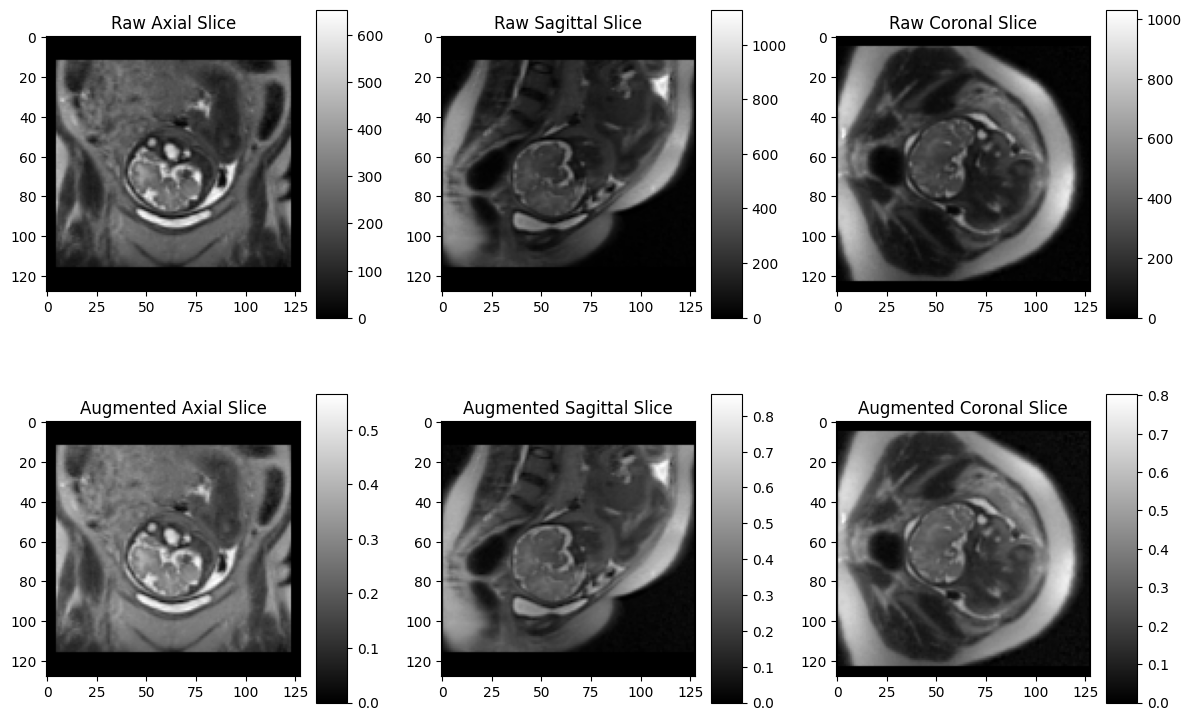

In [ ]:
from monai.transforms import LoadImage
import matplotlib.pyplot as plt

# Step 1: Load the raw image (unaugmented) directly
image_path = train_ds.data[0]["image"]  # Get the raw image path from train_ds
raw_image = LoadImage()(image_path)  # Load the image directly (no transformations)

# Ensure the raw image has the same channel-first format as augmented images
if raw_image.ndim == 3:  # [H, W, D]
    raw_image = raw_image[np.newaxis, ...]  # Add channel dimension to make it [C, H, W, D]

# Step 2: Get the augmented image (with augmentations applied)
augmented_case = train_ds[0]  # Apply transformations via train_ds
augmented_img = augmented_case["image"]  # Augmented image

print("Raw Image Shape:", raw_image.shape)
print("Augmented Image Shape:", augmented_img.shape)

# Step 3: Visualize the raw and augmented images
plt.figure("Raw and Augmented Example", (12, 8))

# --- First Row: Raw Image ---
# Axial View
ax1 = plt.subplot(2, 3, 1)
plt.title("Raw Axial Slice")
im1 = plt.imshow(raw_image[0, :, :, raw_image.shape[-1] // 2], cmap="gray")
plt.colorbar(im1, ax=ax1, shrink=0.8, aspect=10)

# Coronal View
ax2 = plt.subplot(2, 3, 2)
plt.title("Raw Sagittal Slice")
im2 = plt.imshow(raw_image[0, :, raw_image.shape[-2] // 2, :], cmap="gray")
plt.colorbar(im2, ax=ax2, shrink=0.8, aspect=10)

# Sagittal View
ax3 = plt.subplot(2, 3, 3)
plt.title("Raw Coronal Slice")
im3 = plt.imshow(raw_image[0, raw_image.shape[-3] // 2, :, :], cmap="gray")
plt.colorbar(im3, ax=ax3, shrink=0.8, aspect=10)

# --- Second Row: Augmented Image ---
# Axial View
ax4 = plt.subplot(2, 3, 4)
plt.title("Augmented Axial Slice")
im4 = plt.imshow(augmented_img[0, :, :, augmented_img.shape[-1] // 2], cmap="gray")
plt.colorbar(im4, ax=ax4, shrink=0.8, aspect=10)

# Coronal View
ax5 = plt.subplot(2, 3, 5)
plt.title("Augmented Sagittal Slice")
im5 = plt.imshow(augmented_img[0, :, augmented_img.shape[-2] // 2, :], cmap="gray")
plt.colorbar(im5, ax=ax5, shrink=0.8, aspect=10)

# Sagittal View
ax6 = plt.subplot(2, 3, 6)
plt.title("Augmented Coronal Slice")
im6 = plt.imshow(augmented_img[0, augmented_img.shape[-3] // 2, :, :], cmap="gray")
plt.colorbar(im6, ax=ax6, shrink=0.8, aspect=10)

plt.tight_layout()
plt.show()


try visualising the validation cases

In [ ]:

s=round(img_dim/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["image"]
  label_name = val_files[case_num]["label"]
  # case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  label3 = np.squeeze(label)
  mip_x = label3.max(0)
  mip_y = label3.max(1)
  mip_z = label3.max(2)

  print(x, img_name, img_shape, label_shape)

  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1); plt.imshow(img[0, :, :, 60], cmap="gray"); plt.title('Axial Plane');
  plt.subplot(1, 6, 2); plt.imshow(mip_z, cmap="gray"); plt.title('Axial MIP: XY');

  plt.subplot(1, 6, 3); plt.imshow(img[0, :, 60, :], cmap="gray"); plt.title('Sagittal Plane');
  plt.subplot(1, 6, 4); plt.imshow(mip_y, cmap="gray"); plt.title('Sagittal MIP: XZ');

  plt.subplot(1, 6, 5); plt.imshow(img[0, 70, :, :], cmap="gray");plt.title('Coronal Plane');
  plt.subplot(1, 6, 6); plt.imshow(mip_x, cmap="gray"); plt.title('Coronal MIP: YZ');
  plt.show()



Output hidden; open in https://colab.research.google.com to view.



---



Define the network using MONAI (see examples in https://github.com/Project-MONAI/tutorials/tree/master/3d_segmentation)

In [ ]:
from monai.losses import FocalLoss


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 3D Attention UNet
# model = AttentionUnet(spatial_dims=3,
#                        in_channels=1,
#                        out_channels=class_num,
#                        channels=(32, 64, 128, 256, 512),
#                        strides=(2,2,2,2),
#                        kernel_size=3,
#                        up_kernel_size=3,
#                        dropout=0.5).to(device)

# 3D UNet
model = UNet(spatial_dims=3,
            in_channels=1,
            out_channels=class_num,
            channels=(32, 64, 128, 256, 512),
            strides=(2,2,2,2),
            kernel_size=3,
            up_kernel_size=3,
            num_res_units=1,
            act='PRELU',
            norm='INSTANCE',
            dropout=0.5).to(device)


# # Define class weights (increase for small bones)
# class_weights = torch.tensor([
#     0.1,  # Class 0 (background)
#     0.2,  # Class 1
#     0.8,  # Class 2
#     1.0,  # Class 3
#     1.0,  # Class 4
#     2.0,  # Class 5
#     3.9,  # Class 6
#     4.0,  # Class 7 (lowest)
#     3.9,  # Class 8
#     3.8,  # Class 9
#     3.8,  # Class 10
#     2.0,  # Class 11
# ]).cuda()

# # Slightly updated weights
# class_weights = torch.tensor([
#     0.1,  # Background
#     0.2,  # Class 1
#     0.8,  # Class 2
#     0.8,  # Class 3
#     1.0,  # Class 4
#     2.2,  # Class 5
#     4.4,  # Class 6
#     4.5,  # Class 7
#     4.4,  # Class 8
#     3.9,  # Class 9
#     3.3,  # Class 10
#     1.5   # Class 11
# ]).cuda()

# # Slightly updated weights
# class_weights = torch.tensor([
#     0.1,  # Background
#     0.2,  # Class 1
#     0.9,  # Class 2
#     1.2,  # Class 3
#     0.9,  # Class 4
#     2.0,  # Class 5
#     3.8,  # Class 6
#     4.6,  # Class 7
#     3.4,  # Class 8
#     1.9,  # Class 9
#     1.9,  # Class 10
#     1.2   # Class 11
# ]).cuda()

# # Slightly updated weights
# class_weights = torch.tensor([
#     0.1,  # Background
#     0.2,  # Class 1
#     0.5,  # Class 2
#     0.5,  # Class 3
#     1.0,  # Class 4
#     2.3,  # Class 5
#     3.9,  # Class 6
#     5.5,  # Class 7
#     2.9,  # Class 8
#     2.6,  # Class 9
#     1.7,  # Class 10
#     1.1   # Class 11
# ]).cuda()

# Slightly updated weights
class_weights = torch.tensor([
    0.1,  # Background
    0.2,  # Class 1
    0.5,  # Class 2
    0.5,  # Class 3
    1.0,  # Class 4
    2.3,  # Class 5
    5.0,  # Class 6
    5.5,  # Class 7
    4.8,  # Class 8
    3.8,  # Class 9
    3.2,  # Class 10
    1.1   # Class 11
]).cuda()
# # Apply weighted loss
# loss_function = DiceCELoss(to_onehot_y=True, softmax=True, weight=class_weights)

# define the loss and optimiser
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True)

from monai.losses import DiceCELoss, FocalLoss

dice = DiceCELoss(to_onehot_y=True, softmax=True, weight=class_weights)  #weight=class_weights
focal = FocalLoss(to_onehot_y=True, gamma=2.0)

def hybrid_loss(output, target):
    return dice(output, target) + 0.5 * focal(output, target)

# Use this in your training loop
loss_function = hybrid_loss


torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)



Define display, validation and training functions

In [ ]:

qq=64             # depth for slicing
alpha_val = 0.4   # transparency (40% opaque and 60% transparent)
def show_image(img, logit_map, qq):

    plt.figure("cnn output", (12, 36))

    plt.subplot(1, 3, 1)
    plt.imshow(img.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(logit_map, dim=1).detach().cpu().numpy()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_num, cmap="tab20")

    plt.subplot(1, 3, 2)
    plt.imshow(img.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(logit_map, dim=1).detach().cpu().numpy()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_num, cmap="tab20")

    plt.subplot(1, 3, 3)
    plt.imshow(img.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(logit_map, dim=1).detach().cpu().numpy()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_num, cmap="tab20")

    plt.show()


In [ ]:
# def show_image(img, logit_map, qq=None):
#     img_np = img.cpu().numpy()[0, 0]  # Shape: [Z, H, W]
#     pred_np = torch.argmax(logit_map, dim=1).detach().cpu().numpy()[0]

#     if qq is None:
#         qq = img_np.shape[0] // 2  # Use center slice
#     elif qq >= img_np.shape[0]:
#         qq = img_np.shape[0] - 1  # Prevent out-of-bounds

#     plt.subplot(1, 3, 1)
#     plt.imshow(img.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
#     plt.imshow(torch.argmax(logit_map, dim=1).detach().cpu().numpy()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_num, cmap="tab20")

#     plt.subplot(1, 3, 2)
#     plt.imshow(img.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
#     plt.imshow(torch.argmax(logit_map, dim=1).detach().cpu().numpy()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_num, cmap="tab20")

#     plt.subplot(1, 3, 3)
#     plt.imshow(img.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
#     plt.imshow(torch.argmax(logit_map, dim=1).detach().cpu().numpy()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_num, cmap="tab20")

#     plt.show()


In [ ]:
import pandas as pd
import os

# Initialize an empty list to store logs
training_logs = []

# Define the CSV file path
csv_path = os.path.join(root_dir,(roi_type+"logs.csv"))

# Initialize per-class Dice variable as an empty list
per_class_dice = [0] * class_num  # Placeholder for per-class Dice scores

per_class_dice_scores_log = []  # Global storage for per-class Dice


def validation(epoch_iterator_val):
    global per_class_dice_scores_log  # Ensure it's accessible in train()
    model.eval()
    dice_vals = list()
    per_class_dice_scores = []  # Store per-class dice scores

    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)

            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

            dice_metric(y_pred=val_output_convert, y=val_labels_convert)

            # Compute mean Dice score
            dice = dice_metric.aggregate().mean().item()
            dice_vals.append(dice)

            # Compute per-class Dice scores
            per_class_dice = dice_metric.aggregate(reduction=None).cpu().numpy()  # Get per-class Dice scores
            per_class_dice_scores.append(per_class_dice)


            # Display progress
            epoch_iterator_val.set_description("Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice))

        dice_metric.reset()

    mean_dice_val = np.mean(dice_vals)
    per_class_dice_scores_log = np.mean(per_class_dice_scores, axis=0)  # Store globally
    #mean_per_class_dice = np.mean(per_class_dice_scores, axis=0)  # Average across classes

    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0  #to accumulate the total loss for this training epoch
    step = 0        #for tracking the number of batches processed
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True) #progress bar (showing the training progress and loss dynamically)


    for step, batch in enumerate(epoch_iterator):             # Iterates over each batch
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda()) # Retrieves the input images (x) and labels (y)
        logit_map = model(x)                                  # Passes the images x through the model to obtain the predictions
        loss = loss_function(logit_map, y)                    # Computes the loss between the predicted logit_map and the true labels y
        loss.backward()                                       # Backpropagation: Computes gradients of the loss
        epoch_loss += loss.item()                             # Adds the loss for this batch
        optimizer.step()                                      # Updates the model parameters using the gradients calculated
        #scheduler.step()  # Adjust learning rate dynamically
        optimizer.zero_grad()                                 # Resets gradients to zero to prevent accumulation from previous batches

        # progress bar description to display the current training step and the most recent loss.
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))


        # Run validation every `eval_num` steps
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)

            dice_val = validation(epoch_iterator_val)       # the mean Dice score across the validation set
            epoch_loss /= step                              # average epoch loss
            epoch_loss_values.append(epoch_loss)            # appends it to epoch_loss_values (to track training loss over time)
            metric_values.append(dice_val)

            # Save to logs
            training_logs.append({
                "Iteration": global_step,
                "Train Loss": epoch_loss,
                "Validation Mean Dice Best": dice_val_best,
                "Validation Mean Dice Last": dice_val,
                **{f"Dice Class {i}": per_class_dice_scores_log[i-1] for i in range(1, class_num)}  # Store per-class Dice scores
            })



            # Check if this is the best validation score
            if dice_val > dice_val_best:                    # if the current Dice score (dice_val) is the best so far
                dice_val_best = dice_val                    # Updates best values
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, (roi_type+"best_metric_model.pth")) #Saves the model’s state to a file with a name like best_metric_model.pth
                )

                # Prints a message indicating the model was saved with the new best Dice score.
                print("Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))

            else:
                torch.save(
                    model.state_dict(), os.path.join(root_dir, (roi_type+"latest_metric_model.pth")) #Saves the latest model (even if it’s not the best) with a file name
                )

                # Prints a message indicating that the model was not saved as the best
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )

        # Save to CSV every 100 iterations
        if global_step % 100 == 0:
            df = pd.DataFrame(training_logs)
            df.to_csv(csv_path, index=False)
            print(f"📊 Training logs saved to {csv_path}")


        # check how the learning rate is changing during training
        if global_step % 500 == 0:
            print(f"🔄 Updated Learning Rate: {optimizer.param_groups[0]['lr']:.8f}")


        # Visualize predictions every 100 iterations
        if global_step % 100 == 0 and global_step != 0:
                show_image(x,model(x),qq)

        global_step += 1

    return global_step, dice_val_best, global_step_best






---



Preload the pretrained model (if it exists)

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"latest_metric_model.pth"))))
model.eval()

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, ("unet_training_fetus_and_landmarks_40orig40flip_train_8val_11labels_v2_latest_metric_model.pth"))))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.5, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.5, inplace=False)
                (A): PReLU(num_pa

Define training parameters.

In [ ]:
max_iterations = 200000    # the maximum number of training iterations (steps)
eval_num = 100          # the model will be evaluated on the validation set every n steps
post_label = AsDiscrete(to_onehot=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean_batch", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []


Run training. The model will be saved in the folder on your Drive. You can stop training at any moment (e.g., when the Dice is not increasing any more).

In [ ]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )


Output hidden; open in https://colab.research.google.com to view.

Plot average loss and mean dice vs. iterations.

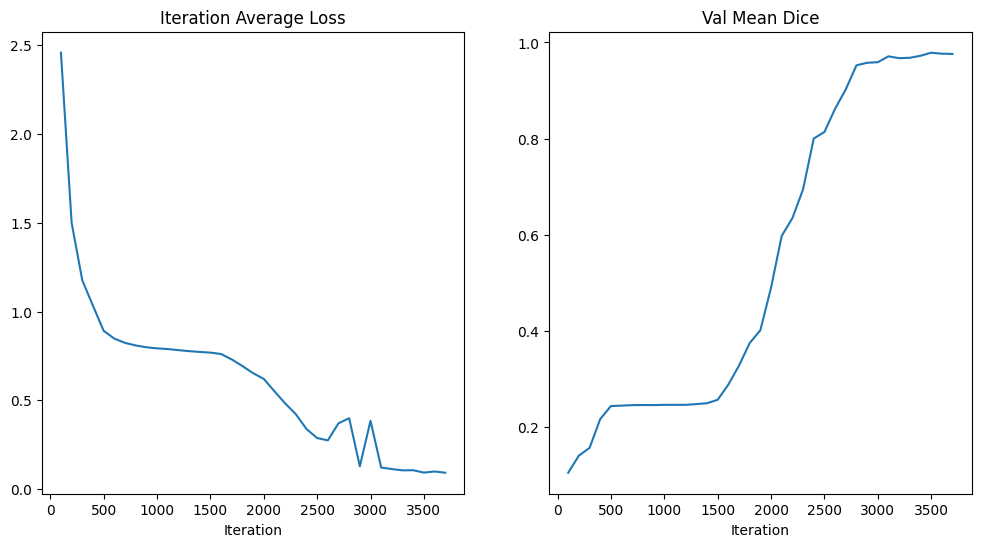

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()



---



Load the output model

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"latest_metric_model.pth"))))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.6, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.6, inplace=False)
                (A): PReLU(num_pa

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"best_metric_model.pth"))))
model.eval()


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, ("unet_training_fetus_and_landmarks_57orig57flip_train_10val_11labels_v4_latest_metric_model.pth"))))
model.eval()

roi_type = 'Round15_unet_training_fetus_and_landmarks_57orig57flip_train_10val_11labels_v4_latest_metric_model'

Try running for one of the validation cases and display the results

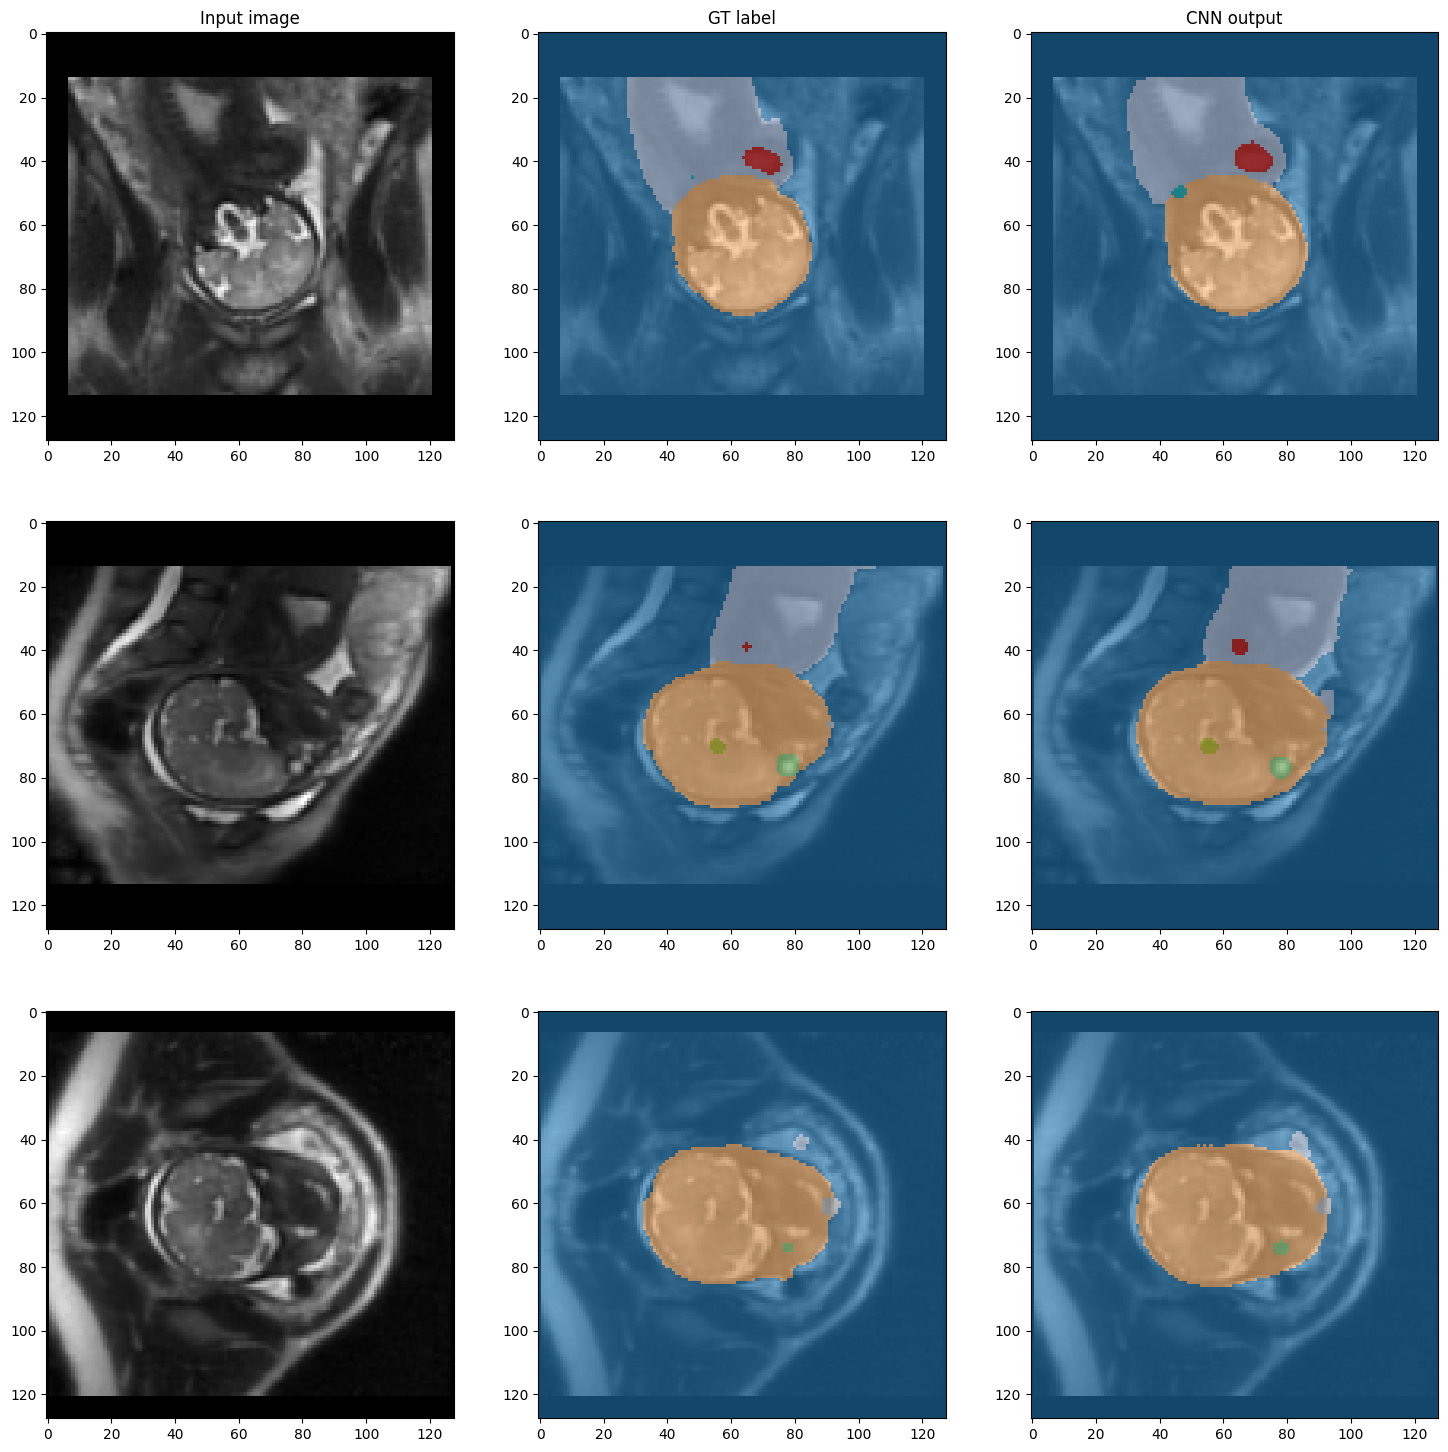

In [ ]:
case_num = 0

class_n = class_num
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = val_files[case_num]["image"]
    cur_case = val_ds[case_num]
    img = cur_case["image"]
    label = cur_case["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title("Input image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="tab20")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="tab20")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="tab20")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="tab20")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="tab20")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="tab20")

    plt.show()

Save CNN segmentation results for all validation images

✅Iterates over all validation images (val_files) and saves each result separately.

In [ ]:

res_dir = root_dir + "/training_segmentation_results/" + roi_type + "_results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["image"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(img_name)[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      # img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds[case_num]["image"]
      label = val_ds[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/MyDrive/BEng_Project2/NEW/training-fetus_3/training_segmentation_results/Round15_unet_training_fetus_and_landmarks_57orig57flip_train_10val_11labels_v4_latest_metric_model_results/cnn-lab-mibirth010201-t2.nii.gz
1 /content/drive/MyDrive/BEng_Project2/NEW/training-fetus_3/training_segmentation_results/Round15_unet_training_fetus_and_landmarks_57orig57flip_train_10val_11labels_v4_latest_metric_model_results/cnn-lab-flip-mibirth010201-t2.nii.gz
2 /content/drive/MyDrive/BEng_Project2/NEW/training-fetus_3/training_segmentation_results/Round15_unet_training_fetus_and_landmarks_57orig57flip_train_10val_11labels_v4_latest_metric_model_results/cnn-lab-mibirth010101-t2.nii.gz
3 /content/drive/MyDrive/BEng_Project2/NEW/training-fetus_3/training_segmentation_results/Round15_unet_training_fetus_and_landmarks_57orig57flip_train_10val_11labels_v4_latest_metric_model_results/cnn-lab-flip-mibirth010101-t2.nii.gz
4 /content/drive/MyDrive/BEng_Project2/NEW/training-fetus_3/training_segme

✅ Processes and saves only one image segmentation result.

In [ ]:
res_dir = root_dir + "/" + roi_type + "results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)

img_name = val_files[case_num]["image"]
case_name = os.path.split(img_name)[1]
out_name = res_dir + "/cnn-lab-" + case_name
img_tmp_info = nib.load(img_name)

out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
nib.save(out_lab_nii, out_name)